In [1]:
# Importing modules
from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
from astropy.cosmology import Planck13
cosmo=Planck13
from astropy . coordinates import Distance
from astropy import units as u
from astropy.table import Table
import pandas as pd
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
import random
import matplotlib
import os

In [2]:
# Pandas display options (personal preference)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
# Matplotlib options
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.visible'] = 'True'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.visible'] = 'True'
plt.rcParams['axes.linewidth'] = 1.2

plt.rcParams['figure.figsize'] = [10,8]
font = {'size'   : 20}
plt.rc('font', **font)

In [4]:
# Reading in GAMA input catalogue data from the equatorial regions
df=pd.read_csv('../GAMA_supplementation/G09_G12_G15_r21.csv')

In [5]:
df=df.set_index('uberID')

In [6]:
df['mag_rt']=8.9-2.5*np.log10(df['flux_rt'])

In [7]:
# Importing galaxies from the GAMA group catalogue
hdul = fits.open('../GAMA_supplementation/G3CGalv10.fits')
data = hdul[1].data
t=Table(data)
names = [name for name in t.colnames if len(t[name].shape) <= 1]
df_gals=t[names].to_pandas()

In [8]:
df_gals=df_gals.set_index('CATAID')

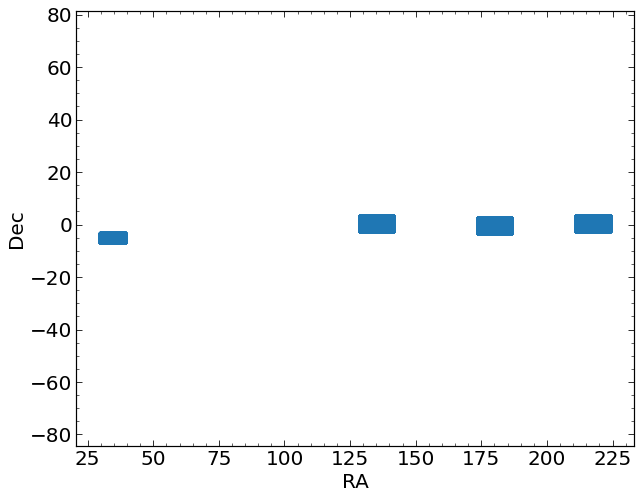

In [9]:
plt.scatter(df_gals['RA'],df_gals['Dec'])
plt.axis('equal')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [10]:
# Removing the G02 region of GAMA 
df_gals=df_gals[df_gals['RA']>100]

In [11]:
# Crossmatching GAMA input catalogue with spec galaxies
from astropy.coordinates import SkyCoord
import astropy.units as u

max_sep=1*u.arcsec
parent = SkyCoord(ra=df['RAmax'].values*u.degree, dec=df['Decmax'].values*u.degree)
gama = SkyCoord(ra=df_gals['RA'].values*u.degree, dec=df_gals['Dec'].values*u.degree)
idx, d2d, d3d = parent.match_to_catalog_sky(gama)
sep_constraint = d2d < max_sep
parent_matches=df.iloc[sep_constraint]
gama_matches=df_gals.iloc[idx[sep_constraint]]

In [12]:
# Removing the spectroscopic galaxies from the photometric catalogue
df=df.drop(parent_matches.index)

In [13]:
#df_gals=df_gals.loc[gama_matches.index]

In [14]:
#df_gals['mag_rt']=parent_matches['mag_rt'].values

In [15]:
# Reading in GAMA groups
dfHalo=pd.read_csv('../GAMA_supplementation/GAMA_groups.csv')

In [16]:
dfHalo=dfHalo.set_index('GroupID')

In [17]:
dfHalo['Z']=dfHalo['IterCenZ']
dfHalo['RA']=dfHalo['IterCenRA']
dfHalo['Dec']=dfHalo['IterCenDec']

In [18]:
# Removing G02
dfHalo=dfHalo[(dfHalo['RA']>100)]
df_gals=df_gals[(df_gals['RA']>100)]

In [19]:
H0 = cosmo.H(0)
h=H0.value/100

In [20]:
dfHalo['LumDistance'] = cosmo.luminosity_distance(np.array(dfHalo['Z'])).value * h * 1e6
df_gals['LumDistance'] = cosmo.luminosity_distance(np.array(df_gals['Z'])).value  * h * 1e6

In [21]:
# Magnitude to luminosity conversion
def lumconv(mag):
    return  10**(0.4 *(4.67- mag))

# Luminosity to halo mass conversion 
def massconv(lum):
    return 1e14 * h**-1 * (0.81) * (lum/(10**11.5))**(1.01)

In [22]:
# K corrections
a = [0.2085, 1.0226, 0.5237, 3.5902, 2.3843]
zref = 0
Q0 = 1.75
zp = 0.2


def kcorr(z):
    k=0
    for i in range(len(a)):
        k+= (a[i] * (z - zp)**i)

    return k - (Q0 * (z-zref))


df_gals['Kcorr'] = df_gals['Z'].apply(kcorr)

In [23]:
# Finding luminosity of GAMA galaxies
df_gals['AbMag'] = df_gals['Rpetro']-5*np.log10(df_gals['LumDistance'])+5 - df_gals['Kcorr']
df_gals['lum']=lumconv(df_gals['AbMag'])

In [24]:
# Summing the luminosity of group members
lum19_raw_arr=[]
for halo in tqdm(dfHalo.index):
    lum19_raw_arr.append(sum(df_gals[df_gals['GroupID']==halo]['lum']))

  0%|          | 0/23654 [00:00<?, ?it/s]

In [25]:
dfHalo['lum19raw']=lum19_raw_arr

In [26]:
# Finding the r<19.8 and r<21 luminosity extrapolation factor

z_arr=np.linspace(0,0.6,1000)
distance_arr=cosmo.luminosity_distance(np.linspace(0,0.6,1000)).value * h * 1e6

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def mlim19(distance):
    idx=find_nearest(distance_arr,distance)
    nearest_z=z_arr[idx]
    return 19.8 - 5*np.log10(distance) + 5 - kcorr(nearest_z)

def mlim21(distance):
    idx=find_nearest(distance_arr,distance)
    nearest_z=z_arr[idx]
    return 21 - 5*np.log10(distance) + 5 - kcorr(nearest_z)


def sch(M,M_star,alpha,phi):
    return 0.4 * np.log(10) * phi * (10**(0.4*(M_star - M)*(alpha+1))) * np.exp(-10**(0.4*(M_star - M)))


alpha=-1.26
M_star=-20.71
phi_star=10**-2.02


from scipy import integrate

def lumest(M,M_star,alpha,phi):
    return 10**(-0.4*M) * sch(M, M_star, alpha, phi)

num = integrate.quad(lumest,-30,-14,args=(M_star,alpha,phi_star))[0]

Lumfacarr19=[]
Lumfacarr21=[]

for i in tqdm(dfHalo.index):
    Lumfacarr19.append(num / integrate.quad(lumest,-30,mlim19(dfHalo['LumDistance'][i]),args=(M_star,alpha,phi_star))[0])
    Lumfacarr21.append(num / integrate.quad(lumest,-30,mlim21(dfHalo['LumDistance'][i]),args=(M_star,alpha,phi_star))[0])

    
dfHalo['Lumfac19'] = Lumfacarr19
dfHalo['Lumfac21'] = Lumfacarr21



  0%|          | 0/23654 [00:00<?, ?it/s]

In [27]:
# Total luminosity as the raw luminosity of group members multiplied by extrapolation factor
dfHalo['lum19']=dfHalo['lum19raw'] * dfHalo['Lumfac19']

In [28]:
# Luminosity to mass
dfHalo['mass19']=massconv(dfHalo['LumB'])

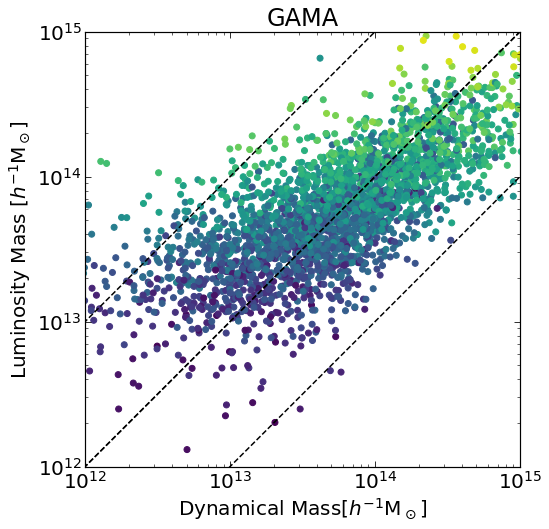

In [30]:
# Comparing the dynamical mass of groups to the luminosity mass

sample=dfHalo[(dfHalo['Nfof']>4) & (dfHalo['MassAfunc']>0) & (dfHalo['mass19']>0)]

plt.scatter(sample['MassAfunc'],sample['mass19'],c=sample['Z'])
plt.plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
plt.plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
plt.plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
plt.plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
plt.xlim(1e12,1e15)
plt.ylim(1e12,1e15)
plt.xlabel('Dynamical Mass[$h^{-1} \mathrm{M_\odot}$]')
plt.ylabel('Luminosity Mass [$h^{-1} \mathrm{M_\odot}$]')
plt.gca().set_aspect('equal')
plt.xscale('log')
plt.yscale('log')
plt.title('GAMA')
plt.show()
plt.show()

In [33]:
# Halo properties of GAMA groups, e.g. r_200 and v_200

dfHalo['Distance'] = cosmo.angular_diameter_distance(np.array(dfHalo['Z'])).value*h*1e6

def H(z):
    return H0.value * np.sqrt(cosmo.Om0*((1+z)**3)+1-cosmo.Om0)

dfHalo['H']=dfHalo['Z'].apply(H)

from astropy.constants import G
GMpc = G.to(u.M_sun**-1 * u.km**2 * u.s**-2 * u.Mpc).value
Gpc = G.to(u.M_sun**-1 * u.km**2 * u.s**-2 * u.pc).value

delta=200

dfHalo['r_200']=(((2*GMpc*dfHalo['mass19'])/(delta * dfHalo['H']**2))**(1/3))*1e6

dfHalo['v_200']=10*dfHalo['H']*dfHalo['r_200']/1e3

dfHalo['Ang_link']=dfHalo['r_200']/dfHalo['Distance']

from astropy.constants import c
C=c.value

dfHalo['V'] = (cosmo.H0*cosmo.comoving_distance(np.array(dfHalo['Z']))).value/(1+dfHalo['Z'])*1e3

df['V']=(cosmo.H0*cosmo.comoving_distance(np.array(df['z_norm']))).value/(1+df['z_norm'])*1e3

In [34]:
dfHalo['RA']=dfHalo['IterCenRA']
dfHalo['Dec']=dfHalo['IterCenDec']

df['RA']=df['RAmax']
df['Dec']=df['Decmax']

In [35]:
# Creating KDtrees of galaxies and groups in angular and velocity space

import math
from sklearn.neighbors import KDTree

dfHalo['DecRad'] = (dfHalo['Dec']).apply(math.radians)
dfHalo['RARad'] = (dfHalo['RA']).apply(math.radians)
df['DecRad'] = (df['Dec']).apply(math.radians)
df['RARad'] = (df['RA']).apply(math.radians)

ANG_halo=np.array(list(zip(dfHalo['RARad'],dfHalo['DecRad'])))
ANGTree_halo=KDTree(ANG_halo, leaf_size=2) 

ANG_gal=np.array(list(zip(df['RARad'],df['DecRad'])))
ANGTree_gal=KDTree(ANG_gal, leaf_size=2) 

VEL_halo=np.array(list(zip(dfHalo['V'])))
VELTree_halo=KDTree(VEL_halo, leaf_size=2) 

VEL_gal=np.array(list(zip(df['V'])))
VELTree_gal=KDTree(VEL_gal, leaf_size=2) 

In [36]:
dfHalo['raw_index']=range(len(dfHalo))

In [38]:
# Using KDtrees to find all photometric galaxies within 3 R_200 and 40 V_200 of each halo
# This comes in the form of a dictionary called groups

groups={}

for halo in tqdm(dfHalo.index):
    
    ANGind = ANGTree_gal.query_radius(ANG_halo[[int(dfHalo.loc[halo]['raw_index'])]], r=3*dfHalo['Ang_link'][halo])
    
    if len(ANGind[0])>0:
        VELtree = KDTree(VEL_gal[ANGind[0]], leaf_size=2)
        ind = VELtree.query_radius(VEL_halo[[int(dfHalo.loc[halo]['raw_index'])]], r=40*dfHalo['v_200'][halo])
        groups[halo]=(df.iloc[ANGind[0]]).iloc[ind[0]].index.values
    else:
        groups[halo]=[]

  0%|          | 0/23654 [00:00<?, ?it/s]

In [40]:
# Angular separation function
def angsep(lon1, lat1, lon2, lat2):

    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.arctan2(np.hypot(num1, num2), denominator)

In [41]:
# This loop goes through the groups dictionary we just made
# It then makes a list of the halo in the association, the galaxy, their velocity and radial difference, and whether the match is true or not

halos=[]
gals=[]
vel_diff=[]
rad_diff=[]

for halo in tqdm((groups)):
    for gal in groups[halo]:
        halos.append(halo)
        gals.append(gal)
        vel_diff.append(abs(dfHalo['V'][halo] - df['V'][gal])/dfHalo['v_200'][halo])
        rad_diff.append((angsep(dfHalo['RARad'][halo],dfHalo['DecRad'][halo],
                                df.loc[gal]['RARad'],df.loc[gal]['DecRad']))/dfHalo['Ang_link'][halo])

  0%|          | 0/23654 [00:00<?, ?it/s]

In [42]:
# Adding the columns to the probdf dataframe
probdf=pd.DataFrame()
probdf['halo']=halos
probdf['gal']=gals
probdf['vel_diff']=vel_diff
probdf['rad_diff']=rad_diff

In [48]:
# Importing the halo profile established from the previous notebook
fracs=np.load('fracs.npy')
r=np.load('r.npy')
vel=np.load('vel.npy')

In [49]:
# Creating the spline, the same way as before
r_grid=np.linspace(0,3,100)
vel_grid=np.linspace(0,40,100)
r_mesh, vel_mesh = np.meshgrid(r_grid, vel_grid, indexing='xy')
Z = np.zeros((np.array(r).size, np.array(vel).size))

In [50]:
import scipy as sp
import scipy.interpolate
spline = sp.interpolate.Rbf(r,vel,fracs,smooth=0.05)
Z = spline(r_mesh,vel_mesh)

### Finding probabilities for each galaxy-group association

In [ ]:
# dfn is a placeholder dataframe
# It contains the entire range of possible z (and zeta) values for the p(z)'s
# It's needed because the p(z) given from each file only contains a range of values around the peak, not the entire range

dfn=pd.DataFrame()
dfn['izeta']=np.arange(1,161)
dfn=dfn.set_index('izeta')
dfn['zeta']=0.0036620409622270325 + ((dfn.index-1)*0.007324081924454079)
dfn['z']=np.exp(dfn['zeta'])-1

In [55]:
z_grid=np.array(dfn['z'])
vel_array=(cosmo.H0*cosmo.comoving_distance(z_grid)).value/(1+z_grid)*1e3

In [58]:
probs=[]

In [61]:
ix

1057282

In [59]:
# Iterating through probdf, giving a probability for each galaxy-group association
for ix in tqdm(probdf.index):
    halo=int(probdf.loc[ix]['halo'])
    gal=int(probdf.loc[ix]['gal'])
    
    # If halo is in G09 region, then access the G09 posteriors
    if dfHalo.loc[halo]['RA']<150:
        # Reading in posterior for galaxy
        hdul = fits.open('../g09_posteriors/'+'topz_pzeta_'+str(gal)+'.fits')
        data = hdul[1].data
        t=Table(data)
        names = [name for name in t.colnames if len(t[name].shape) <= 1]
        # Creating df_pos for the given posterior
        df_pos=t[names].to_pandas()
        df_pos=df_pos.set_index('izeta')

        dfn['prob']=0
        # Inserting the probabilities into dfn, the placeholder dataframe
        dfn.loc[df_pos.index,'prob']=df_pos['p'].values
        
        # Angular difference between galaxy and 
        ang_diff=probdf.loc[ix]['rad_diff']

        # Velocity difference array
        vel_diff_array=abs(dfHalo['V'][halo]-vel_array)/dfHalo['v_200'][halo]
        
        # Creating the PDF of halo velocity given the ang_diff and the profile created earlier
        spline_array=spline(ang_diff*np.ones(len(vel_diff_array[vel_diff_array<40])),
                            vel_diff_array[vel_diff_array<40])
        
        #Multplying the PDF of halo velocity with dfn, the galaxy p(z) and then normalising
        probs.append(sum(spline_array*np.array(dfn['prob'])[vel_diff_array<40])/sum(dfn['prob']))
        
    # Doing exactly the same for if the halo is in the G12/G15 regions
    else:
        hdul = fits.open('../GAMA_supplementation/g15_posteriors/'+'topz_pzeta_'+str(gal)+'.fits')
        data = hdul[1].data
        t=Table(data)
        names = [name for name in t.colnames if len(t[name].shape) <= 1]
        df_pos=t[names].to_pandas()
        df_pos=df_pos.set_index('izeta')

        dfn['prob']=0
        dfn.loc[df_pos.index,'prob']=df_pos['p'].values

        ang_diff=probdf.loc[ix]['rad_diff']

        vel_diff_array=abs(dfHalo['V'][halo]-vel_array)/dfHalo['v_200'][halo]

        spline_array=spline(ang_diff*np.ones(len(vel_diff_array[vel_diff_array<40])),
                            vel_diff_array[vel_diff_array<40])

        probs.append(sum(spline_array*np.array(dfn['prob'])[vel_diff_array<40])/sum(dfn['prob']))
        

  0%|          | 0/3332002 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



FileNotFoundError: [Errno 2] No such file or directory: '../g15_posteriors/topz_pzeta_178980914907159.fits'

In [ ]:
# Iterating through probdf, giving a probability for each galaxy-group association
for ix in tqdm(range(1057282,len(probdf)-1)):
    halo=int(probdf.loc[ix]['halo'])
    gal=int(probdf.loc[ix]['gal'])
    
    # If halo is in G09 region, then access the G09 posteriors
    if dfHalo.loc[halo]['RA']<150:
        # Reading in posterior for galaxy
        hdul = fits.open('../g09_posteriors/'+'topz_pzeta_'+str(gal)+'.fits')
        data = hdul[1].data
        t=Table(data)
        names = [name for name in t.colnames if len(t[name].shape) <= 1]
        # Creating df_pos for the given posterior
        df_pos=t[names].to_pandas()
        df_pos=df_pos.set_index('izeta')

        dfn['prob']=0
        # Inserting the probabilities into dfn, the placeholder dataframe
        dfn.loc[df_pos.index,'prob']=df_pos['p'].values
        
        # Angular difference between galaxy and 
        ang_diff=probdf.loc[ix]['rad_diff']

        # Velocity difference array
        vel_diff_array=abs(dfHalo['V'][halo]-vel_array)/dfHalo['v_200'][halo]
        
        # Creating the PDF of halo velocity given the ang_diff and the profile created earlier
        spline_array=spline(ang_diff*np.ones(len(vel_diff_array[vel_diff_array<40])),
                            vel_diff_array[vel_diff_array<40])
        
        #Multplying the PDF of halo velocity with dfn, the galaxy p(z) and then normalising
        probs.append(sum(spline_array*np.array(dfn['prob'])[vel_diff_array<40])/sum(dfn['prob']))
        
    # Doing exactly the same for if the halo is in the G12/G15 regions
    else:
        hdul = fits.open('../GAMA_supplementation/g15_posteriors/'+'topz_pzeta_'+str(gal)+'.fits')
        data = hdul[1].data
        t=Table(data)
        names = [name for name in t.colnames if len(t[name].shape) <= 1]
        df_pos=t[names].to_pandas()
        df_pos=df_pos.set_index('izeta')

        dfn['prob']=0
        dfn.loc[df_pos.index,'prob']=df_pos['p'].values

        ang_diff=probdf.loc[ix]['rad_diff']

        vel_diff_array=abs(dfHalo['V'][halo]-vel_array)/dfHalo['v_200'][halo]

        spline_array=spline(ang_diff*np.ones(len(vel_diff_array[vel_diff_array<40])),
                            vel_diff_array[vel_diff_array<40])

        probs.append(sum(spline_array*np.array(dfn['prob'])[vel_diff_array<40])/sum(dfn['prob']))
        

  0%|          | 0/2274719 [00:00<?, ?it/s]

In [ ]:
probdf['prob']=probs

In [ ]:
probdf.loc[probdf[probdf['prob']<0].index,'prob']=0

In [ ]:
#probdf.to_csv('probdf.csv')

In [ ]:
len(np.unique(probdf['halo']))

In [ ]:
hdul = fits.open('../WAVES/nov3_parquet/cat_matched_paus_untrimmed_Ivan_Baldry.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)
names = [name for name in t.colnames if len(t[name].shape) <= 1]
df_paus=t[names].to_pandas()
del hdul
del data
del cols
del t

In [ ]:
df_paus=df_paus.set_index('UBERID')
df_paus=df_paus[(df_paus['QZ']<3) & (df_paus['CHI2']<50)]
intersect=np.intersect1d(df_paus.index,df.index)
df_paus=df_paus.loc[intersect]
df_paus['Z']=df_paus['ZB']
df_paus['Z_top'] = df.loc[intersect]['z_norm']

In [ ]:
df['Z_paus']=np.nan
df.loc[df_paus.index,'Z_paus']=df_paus['Z'].values

In [ ]:
hdul = fits.open('../WAVES/speccat-matched.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)
names = [name for name in t.colnames if len(t[name].shape) <= 1]
df_spec=t[names].to_pandas()
del hdul
del data
del cols
del t

In [ ]:
df_spec=df_spec.set_index('UBERID')

In [ ]:
intersect=np.intersect1d(df_spec.index,df.index)
df_spec=df_spec.loc[intersect]

In [ ]:
df['Z_spec']=np.nan
df.loc[df_spec.index,'Z_spec']=df_spec['Z'].values

In [ ]:
df['Z_comb']=np.NAN
df.loc[df[df['Z_paus']>0].index,'Z_comb'] = df[df['Z_paus']>0]['Z_paus']
df.loc[df[df['Z_spec']>0].index,'Z_comb'] = df[df['Z_spec']>0]['Z_spec']

In [ ]:
thresholds=np.linspace(0.1,0.5,50)
num_threshold=[]
unique_threshold=[]
tag_diff=[]
photo_diff=[]

In [ ]:
for threshold in tqdm(thresholds):
    num_threshold.append(len(probdf[probdf['prob']>threshold]))
    unique_threshold.append(len(np.unique(probdf[probdf['prob']>threshold]['gal'])))
    df['Z_tag']=np.NAN
    df.loc[probdf[probdf['prob']>threshold]['gal'],'Z_tag']=dfHalo.loc[probdf[probdf['prob']>threshold]['halo']]['Z'].values

    sample=df[(df['Z_tag']>0) & (df['Z_comb']>0) & (df['Z_tag']<0.55)]
    tag_diff.append(np.median(abs(sample['Z_tag']-sample['Z_comb'])/(1+sample['Z_comb'])))
    photo_diff.append(np.median(abs(sample['z_norm']-sample['Z_comb'])/(1+sample['Z_comb'])))

In [ ]:
fig, axs = plt.subplots(2,1, facecolor='w', edgecolor='k',gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace = 0.05, wspace=0)

axs[0].plot(thresholds,tag_diff)
axs[0].xaxis.set_ticklabels([])
axs[0].set_xlim(0.1,0.5)
axs[0].axhline(0.0177,c='k',linestyle='dashed')
axs[0].set_ylabel('Median '+r'$|\Delta z | / (1+z)$')


axs[1].bar(thresholds,num_threshold,width=0.009)
axs[1].set_xlim(0.1,0.5)
axs[1].set_yscale('log')
axs[1].set_ylim(1000,1e6)
axs[1].tick_params(axis='x', which='major', pad=10)
axs[1].set_ylabel('No. > threshold',fontsize=15)

axs[1].set_xlabel('Probability')


plt.savefig('z_refinement.jpg',bbox_inches='tight',dpi=200)



plt.show()

In [ ]:
threshold=0.4
df['Z_tag']=np.NAN
df.loc[probdf[probdf['prob']>threshold]['gal'],'Z_tag']=dfHalo.loc[probdf[probdf['prob']>threshold]['halo']]['Z'].values

sample=df[(df['Z_tag']>0) & (df['Z_comb']>0) & (df['Z_tag']<0.55)]
np.median(abs(sample['Z_tag']-sample['Z_comb'])/(1+sample['Z_comb']))

In [ ]:
len(np.unique(probdf[probdf['prob']>threshold]['gal']))

In [ ]:
plt.figure(figsize=(6,8))
plt.hist((sample['z_peak']-sample['Z_comb'])/(1+sample['Z_comb']),
         bins=np.linspace(-0.1,0.1,101),histtype='step',label='$z_\mathrm{photo}$')
plt.hist((sample['Z_tag']-sample['Z_comb'])/(1+sample['Z_comb']),
         bins=np.linspace(-0.1,0.1,101),histtype='step',label='$z_\mathrm{tag}$')
#plt.axvline(0,c='k',linestyle='dashed',linewidth=2)
plt.xlabel('$\Delta z / (1+z_\mathrm{spec})$')
plt.ylabel('Counts')
plt.legend(frameon=False)
#plt.savefig('z_tag_z_photo_0.5.jpg',bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
plt.scatter(sample['Z_comb'],
            sample['Z_tag'],
            s=1,c='k',linewidth=0)
im=plt.hexbin(sample['Z_comb'],sample['Z_tag'],gridsize=(60,round(60*2/3)),
              cmap='turbo',extent=(-0.01,0.55,-0.01,0.55),mincnt=5,linewidths=0)#norm=matplotlib.colors.LogNorm())

plt.plot([0,0.55],[0,0.55],c='k',linestyle='dashed',linewidth=1)
plt.xlabel(r'$z_\mathrm{spec}$',fontsize=20)
plt.ylabel(r'$z_\mathrm{tag}$',fontsize=20)
plt.xlim(-0.01,0.55)
plt.ylim(-0.01,0.55)

cbar=plt.colorbar().set_label(label='Counts')
im.figure.axes[1].tick_params(labelsize=20)
#plt.savefig('z_tag_z_spec_0.5.jpg',bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
np.median(abs(sample['Z_tag']-sample['Z_comb'])/(1+sample['Z_comb']))

In [ ]:
np.median(abs(sample['z_norm']-sample['Z_comb'])/(1+sample['Z_comb']))

In [ ]:
len(sample[abs((sample['Z_tag']-sample['Z_comb'])/(1+sample['Z_comb']))<0.01])/len(sample)

In [ ]:
1.4826*np.median(abs(((sample['Z_tag']-sample['Z_comb'])/(1+sample['Z_comb'])) - 
                     np.median(((sample['Z_tag']-sample['Z_comb'])/(1+sample['Z_comb'])))))

In [ ]:
dfHalo['N_prob']=dfHalo['Nfof']
dfHalo['N_threshold']=dfHalo['Nfof']

In [ ]:
for i in tqdm(probdf.index):
    halo=probdf['halo'][i]
    dfHalo['N_prob'].loc[halo]+=probdf['prob'][i]
    if probdf['prob'][i] >threshold:
        dfHalo['N_threshold'].loc[halo]+=1

In [ ]:
cmap = matplotlib.cm.get_cmap('viridis')
z_bins=[0,0.1,0.2,0.3,0.4,0.5,0.6]

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=[13, 8])
for i in tqdm(range(len(z_bins)-1)):
    median=[]
    z_low=z_bins[i]
    z_high=z_bins[i+1]
    sample=dfHalo[(dfHalo['Z']>z_low) & (dfHalo['Z']<z_high)]
    for j in (range(len(n_bins[:-1]))):
        n_low=n_bins[j]
        n_high=n_bins[j+1]
        sample_new=sample[(sample['Nfof']>n_low) & (sample['Nfof']<n_high)]
        if len(sample_new)>0:
            median.append(np.median(sample_new['N_prob']))
        else:
            median.append(np.NAN)
    im=ax1.plot(n_centres,np.array(median)/np.array(n_centres),c=cmap(i/5),linewidth=2)
ax1.scatter(dfHalo['Nfof'],dfHalo['N_prob']/dfHalo['Nfof'],linewidth=0,s=5,c='k')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$N_\mathrm{FoF}$')
ax1.set_ylabel('$N_\mathrm{Supplemented}/N_\mathrm{FoF}$')
ax1.set_xlim(1.5,200)
ax1.set_ylim(0.8,200)

axins = inset_axes(
    ax1,
    width="70%",  # width: 5% of parent_bbox width
    height="5%",  # height: 50%
    loc="upper center",
    bbox_to_anchor=(0.4,-0.1, 1, 1),
    bbox_transform=ax2.transAxes,
    borderpad=0)

im=ax1.scatter(dfHalo['Nfof']*1e6,dfHalo['Nfof']*1e6,c=dfHalo['Z'])

fig.colorbar(im,cax=axins,label=r'$z$',pad=0.02,ticks=z_bins,boundaries=z_bins,orientation='horizontal')



plt.show()


In [ ]:
mass_bins=[12.5,13,13.5,14,14.5,15,15.5]

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=[13, 8])
for i in tqdm(range(len(mass_bins)-1)):
    median=[]
    mass_low=mass_bins[i]
    mass_high=mass_bins[i+1]
    sample=dfHalo[(np.log10(dfHalo['mass19'])>mass_low) & (np.log10(dfHalo['mass19'])<mass_high)]
    for j in (range(len(n_bins[:-1]))):
        n_low=n_bins[j]
        n_high=n_bins[j+1]
        sample_new=sample[(sample['Nfof']>n_low) & (sample['Nfof']<n_high)]
        if len(sample_new)>0:
            median.append(np.median(sample_new['N_prob']))
        else:
            median.append(np.NAN)
    im=ax1.plot(n_centres,np.array(median)/np.array(n_centres),c=cmap(i/(len(mass_bins)-1)),linewidth=2)
ax1.scatter(dfHalo['Nfof'],dfHalo['N_prob']/dfHalo['Nfof'],linewidth=0,s=5,c='k')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$N_\mathrm{FoF}$')
ax1.set_ylabel('$N_\mathrm{Supplemented}/N_\mathrm{FoF}$')
ax1.set_xlim(1.5,200)
ax1.set_ylim(0.8,200)

axins = inset_axes(
    ax1,
    width="70%",  # width: 5% of parent_bbox width
    height="5%",  # height: 50%
    loc="upper center",
    bbox_to_anchor=(0.4,-0.1, 1, 1),
    bbox_transform=ax2.transAxes,
    borderpad=0)

sample=dfHalo[(dfHalo['mass19']>10**12.5) & (dfHalo['mass19']<10**15.5)]

im=ax1.scatter(sample['Nfof']*1e6,sample['Nfof']*1e6,c=np.log10(sample['mass19']))

fig.colorbar(im,cax=axins,label=r'$\mathrm{log(Mass/}\mathrm{M}_\odot h^{-1})$',pad=0.02,ticks=mass_bins,boundaries=mass_bins,orientation='horizontal')


plt.show()


In [ ]:
plt.scatter(dfHalo['Z'],dfHalo['Lumfac19'])

In [ ]:
np.median(dfHalo[dfHalo['Nfof']>4]['N_prob']/dfHalo[dfHalo['Nfof']>4]['Nfof'])

In [ ]:
lum_sup_arr=[]

In [ ]:
for halo in tqdm(dfHalo.index):
    lum=dfHalo.loc[halo]['lum19raw']
    subset=probdf[probdf['halo']==halo]
    distance=dfHalo.loc[halo]['LumDistance']
    Z=dfHalo.loc[halo]['Z']
    df_gals['AbMag'] = df_gals['Rpetro']-5*np.log10(df_gals['LumDistance'])+5 - df_gals['Kcorr']
    subset_gals=df.loc[subset['gal']]
    subset_gals['AbMag']=subset_gals['mag_rt']-5*np.log10(distance)+5-kcorr(Z)
    subset_gals['lum']=lumconv(subset_gals['AbMag'])
    lum_sup_arr.append(lum + sum(subset['prob'].values * subset_gals['lum'].values))


In [ ]:
dfHalo['lum_sup']=np.array(lum_sup_arr)*dfHalo['Lumfac21']

In [ ]:
sample=dfHalo[dfHalo['Z']>0.5]

In [ ]:
np.mean(sample['lum_sup']/sample['LumB'])

In [ ]:
plt.scatter(sample['LumB'],sample['lum_sup'],c=sample['Z'])
plt.plot([1e7,6e13],[1e7,6e13],c='k')
plt.xscale('log')
plt.yscale('log')

In [ ]:
dfHalo['mass_sup']=massconv(dfHalo['lum_sup'])

In [ ]:
fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',gridspec_kw={'width_ratios': [1, 1]},figsize=(16,8))
fig.subplots_adjust(hspace = 0, wspace=0.15)
axs=axs.ravel()

sample=dfHalo[(dfHalo['Nfof']>1) & (dfHalo['mass19']>0)]

axs[0].hexbin(massconv(sample['LumB']),
              sample['mass_sup'],
              gridsize=(70,round(70*2/3)),cmap='turbo',extent=(10,15,10,15),mincnt=1,
              linewidths=0,vmin=0,vmax=500,xscale='log',yscale='log')#,norm=matplotlib.colors.LogNorm())
axs[0].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[0].plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
axs[0].plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
axs[0].set_xlim(1e11,1e15)
axs[0].set_ylim(1e11,1e15)
axs[0].set_xlabel('Extrapolated Luminosity Mass [$h^{-1}\mathrm{M_\odot}$]')
axs[0].set_ylabel('Supplemented Luminosity Mass [$h^{-1}\mathrm{M_\odot}$]')
#axs[0].xaxis.set_ticklabels([1e10,1e11,1e12])
axs[0].set_title('$N \geq 2$')
axs[0].set_aspect('equal', adjustable='box')



sample=dfHalo[(dfHalo['Nfof']>4) & (dfHalo['mass19']>0)]

axs[1].hexbin(massconv(sample['LumB']),
              sample['mass_sup'],
              gridsize=(70,round(70*2/3)),cmap='turbo',extent=(10,15,10,15),mincnt=1,
              linewidths=0,vmin=0,vmax=500,xscale='log',yscale='log')#,norm=matplotlib.colors.LogNorm())
axs[1].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[1].plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
axs[1].plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
axs[1].set_xlim(1e11,1e15)
axs[1].set_ylim(1e11,1e15)
axs[1].set_xlabel('Extrapolated Luminosity Mass [$h^{-1}\mathrm{M_\odot}$]')
#axs[0].xaxis.set_ticklabels([1e10,1e11,1e12])
axs[1].set_title('$N \geq 5$')
axs[1].set_aspect('equal', adjustable='box')
axs[1].yaxis.set_ticklabels([])



#cax = fig.add_axes([0.85,0.1,0.03,0.8]) 
im = plt.gca().get_children()[0]
fig.colorbar(im, ax=axs,pad=0.01,fraction=0.0225,label='Counts')

#plt.savefig('lum_mass_sup_lum_mass.jpg', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
plt.scatter(sample['mass_sup'],sample['mass_sup']/sample['mass19'],c=sample['Z'])
plt.xscale('log')
plt.axhline(1,c='k')

In [ ]:
fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',gridspec_kw={'width_ratios': [1, 1]},figsize=(16,8))
fig.subplots_adjust(hspace = 0, wspace=0.15)
axs=axs.ravel()

sample=dfHalo[(dfHalo['Nfof']>1) & (dfHalo['MassAfunc']>0) & (dfHalo['mass19']>0)]

axs[0].hexbin(sample['MassAfunc'],
              sample['mass_sup'],
              gridsize=(70,round(70*2/3)),cmap='turbo',extent=(10,15,10,15),mincnt=1,
              linewidths=0,vmin=0,vmax=40,xscale='log',yscale='log')
axs[0].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[0].plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
axs[0].plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
axs[0].set_xlim(1e11,1e15)
axs[0].set_ylim(1e11,1e15)
axs[0].set_xlabel('Dynamical Mass [$h^{-1}\mathrm{M_\odot}$]')
axs[0].set_ylabel('Supplemented Luminosity Mass [$h^{-1}\mathrm{M_\odot}$]')
#axs[0].xaxis.set_ticklabels([1e10,1e11,1e12])
axs[0].set_title('$N \geq 2$')
axs[0].set_aspect('equal', adjustable='box')



sample=dfHalo[(dfHalo['Nfof']>4) & (dfHalo['MassAfunc']>0) & (dfHalo['mass19']>0)]

axs[1].hexbin(sample['MassAfunc'],
              sample['mass_sup'],
              gridsize=(70,round(70*2/3)),cmap='turbo',extent=(10,15,10,15),mincnt=1,
              linewidths=0,vmin=0,vmax=40,xscale='log',yscale='log')
axs[1].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[1].plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
axs[1].plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
axs[1].set_xlim(1e11,1e15)
axs[1].set_ylim(1e11,1e15)
axs[1].set_xlabel('Dynamical Mass [$h^{-1}\mathrm{M_\odot}$]')
#axs[0].xaxis.set_ticklabels([1e10,1e11,1e12])
axs[1].set_title('$N \geq 5$')
axs[1].set_aspect('equal', adjustable='box')
axs[1].yaxis.set_ticklabels([])



#cax = fig.add_axes([0.85,0.1,0.03,0.8]) 
im = plt.gca().get_children()[0]
fig.colorbar(im, ax=axs,pad=0.01,fraction=0.0225,label='Counts')

plt.savefig('dyn_mass_sup_lum_mass.jpg', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
#dfHalo.to_csv('GAMA_groups.csv')

In [ ]:
dfn=pd.DataFrame()
dfn['izeta']=np.arange(1,161)
dfn=dfn.set_index('izeta')
dfn['zeta']=0.0036620409622270325 + ((dfn.index-1)*0.007324081924454079)
dfn['z']=np.exp(dfn['zeta'])-1

In [ ]:
def random_p_z():
    gal=np.random.choice(df_paus.index)
    hdul = fits.open('../g09_posteriors/'+'topz_pzeta_'+str(gal)+'.fits')
    data = hdul[1].data
    t=Table(data)
    names = [name for name in t.colnames if len(t[name].shape) <= 1]
    df_new=t[names].to_pandas()
    df_new=df_new.set_index('izeta')

    dfn['prob']=0
    dfn.loc[df_new.index,'prob']=df_new['p'].values
    z=df_paus.loc[gal]['ZB']
    mag=df.loc[gal]['mag_rt']
    
    return dfn,z,gal,mag

In [ ]:
fig = plt.figure(figsize=(20,20))
spec = matplotlib.gridspec.GridSpec(ncols=3, nrows=3) # 6 columns evenly divides both 2 & 3
plt.subplots_adjust(wspace=0.1,hspace=0.25)

for i in [0,1,2]:
    for j in [0,1,2]:
        ax=fig.add_subplot(spec[i,j])
        dfn,z,gal,mag=random_p_z()
        ax.plot(dfn['z'],dfn['prob'])
        ax.axvline(z,c='k',linestyle='dashed')
        ax.set_xlim(0,0.6)
        ax.set_yticks([])
        ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
        ax.set_title('UBERID: '+str(gal)+'   '+'$r_\mathrm{mag}=$'+str(round(mag,2)),fontsize=15)
        ax.set_xlabel(r'$z$')
        ax.set_ylabel(r'$p(z)$')
#plt.savefig('topz_examples.jpg',bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
np.log10(massconv(10**10.5))